## Dependencies

In [1]:
%pip install --upgrade --quiet fastai fastcore fastdownload duckduckgo-search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 61.7 MB/s eta 0:00:00


## 1. Downloading images of mario and luigi

In [2]:
from duckduckgo_search import DDGS, AsyncDDGS
import asyncio

async def search_images(keywords, max_results=5):
    async with AsyncDDGS() as ddgs:
        results = [r['image'] async for r in ddgs.images(keywords, max_results=max_results)]
        return results

In [3]:
from fastdownload import download_url
from fastai.vision.all import *

<ipython-input-2-bb1073b30bfc>:5: RuntimeWarning: coroutine 'AsyncSession.close' was never awaited
  async with AsyncDDGS() as ddgs:


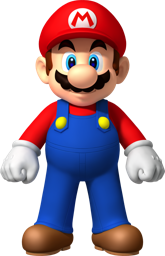

In [4]:
# you might check this picture at https://pixspy.com/

dest = 'mario.jpg'

r = await search_images("mario")
download_url(r[0], dest=dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

<ipython-input-2-bb1073b30bfc>:5: RuntimeWarning: coroutine 'AsyncSession.close' was never awaited
  async with AsyncDDGS() as ddgs:


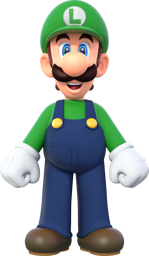

In [5]:
dest = 'luigi.jpg'

r = await search_images("luigi")
download_url(r[0], dest=dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

## 2. Creating the dataset

In [6]:
searches = 'mario', 'luigi'
path = Path('mario_or_luigi')
from time import sleep

for search in searches:
    dest = (path/search)
    dest.mkdir(exist_ok=True, parents=True)

    results = await search_images(f'{search} photo', max_results=25)
    download_images(dest, urls=results)
    sleep(10)

    results = await search_images(f'super {search} photo', max_results=25)
    download_images(dest, urls=results)
    sleep(10)

    results = await search_images(f'baby {search} photo', max_results=25)
    download_images(dest, urls=results)
    sleep(10)
    resize_images(path/search, max_size=400, dest=path/search)

<ipython-input-2-bb1073b30bfc>:5: RuntimeWarning: coroutine 'AsyncSession.close' was never awaited
  async with AsyncDDGS() as ddgs:
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

## 3. Train a model

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

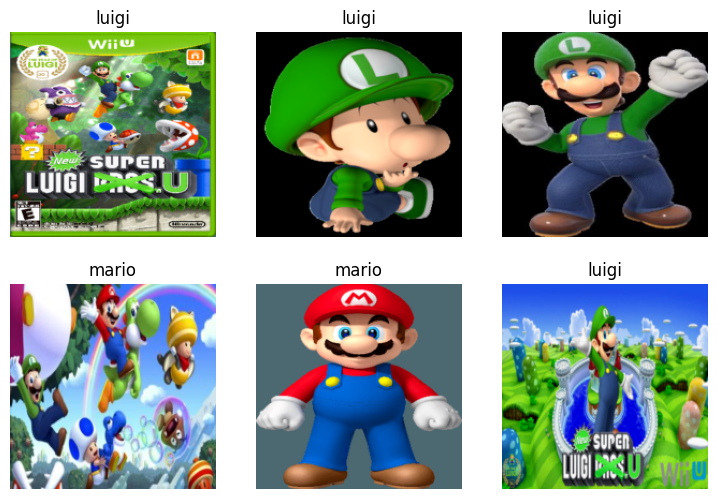

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # ImageBlocks are inputs, CategoryBlocks are targets
    get_items=get_image_files, # get the image files
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # split the files into train and valid
    get_y=parent_label, # get the labels
    item_tfms=[Resize(192, method='squish')] # resize the images, squish means to crop the image
).dataloaders(path, bs=32) # batch size

dls.show_batch(max_n=6) # show 6 images

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3) # fine_tune means to train the model with the given epochs on the given data

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.557899,1.586012,0.500000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.605710,0.435793,0.192308,00:01
1,0.425965,0.217205,0.038462,00:00
2,0.306028,0.171570,0.038462,00:01


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories)

## 4. Predicting with the model

In [15]:
is_mario_or_luigi,_,probs = learn.predict(PILImage.create('mario.jpg'))
print(f"This is a: {is_mario_or_luigi}.")
print(f"Probability it's Mario or Luigi: {probs[0]:.4f}")

This is a: mario.
Probability it's Mario or Luigi: 0.0353
